In [ ]:
%pip install pandas
%pip install json
%pip install seaborn
%pip install textwrap
%pip install atplotlib
%pip install pillow
%pip install wordcloud
%pip install nltk
%pip install numpy

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Analysis of the last Bundestag debate before the election, on 2025-02-11

In [1]:
# Import libraries
import pandas as pd
import json

In [4]:
# Open JSON file
with open('pollux-data-67.json', 'r') as openfile:
    # Read from json file
    json_object = json.load(openfile)

In [5]:
# Convert json to dataframe
df = pd.json_normalize(json_object['data'])
# Show first 5 rows
df.head()

,date,role,text_raw,speaker_id,description,speech_id,sessionno,agenda_id,source_file,legislativeperiod,agenda_type,agenda_nr,party_id,name,topic,position,speechno,party
0,2025-02-11,presidency,"[{'seq_no': 0, 'legal_ner': None, 'ner': None,...",11004006,,0_20212_212_0,212,0_20212_212,https://dserver.bundestag.de/btp/20/20212.xml,20,None,0,14,Bärbel Bas,Presidency Action,Präsidentin,0,SPD
1,2025-02-11,presidency,"[{'seq_no': 0, 'legal_ner': None, 'ner': None,...",11004006,,0_20212_212_1,212,0_20212_212,https://dserver.bundestag.de/btp/20/20212.xml,20,None,0,14,Bärbel Bas,Presidency Action,Präsidentin,1,SPD
2,2025-02-11,presidency,"[{'seq_no': 0, 'legal_ner': [{'end_pos': 18, '...",11004346,Vereinbarte Debatte: (Schluss: 12.51 Uhr),1_20212_212_36,212,1_20212_212,https://dserver.bundestag.de/btp/20/20212.xml,20,None,1,2,Yvonne Magwas,Presidency Action,Vizepräsidentin,36,CDU
3,2025-02-11,presidency,"[{'seq_no': 0, 'legal_ner': [{'end_pos': 56, '...",11004346,Vereinbarte Debatte: (Schluss: 12.51 Uhr),1_20212_212_38,212,1_20212_212,https://dserver.bundestag.de/btp/20/20212.xml,20,None,1,2,Yvonne Magwas,Presidency Action,Vizepräsidentin,38,CDU
4,2025-02-11,presidency,"[{'seq_no': 0, 'legal_ner': [{'end_pos': 27, '...",11004346,Vereinbarte Debatte: (Schluss: 12.51 Uhr),1_20212_212_40,212,1_20212_212,https://dserver.bundestag.de/btp/20/20212.xml,20,None,1,2,Yvonne Magwas,Presidency Action,Vizepräsidentin,40,CDU


In [6]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

In [7]:
# Helper function
# Wraps long text in y-axis
def wrap_y_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=rotation)

## Show all speakers without presidency role and number of speeches per speaker and party

In [9]:
# Select speeches of non-president speakers
sel = df[df['role'] != 'presidency']

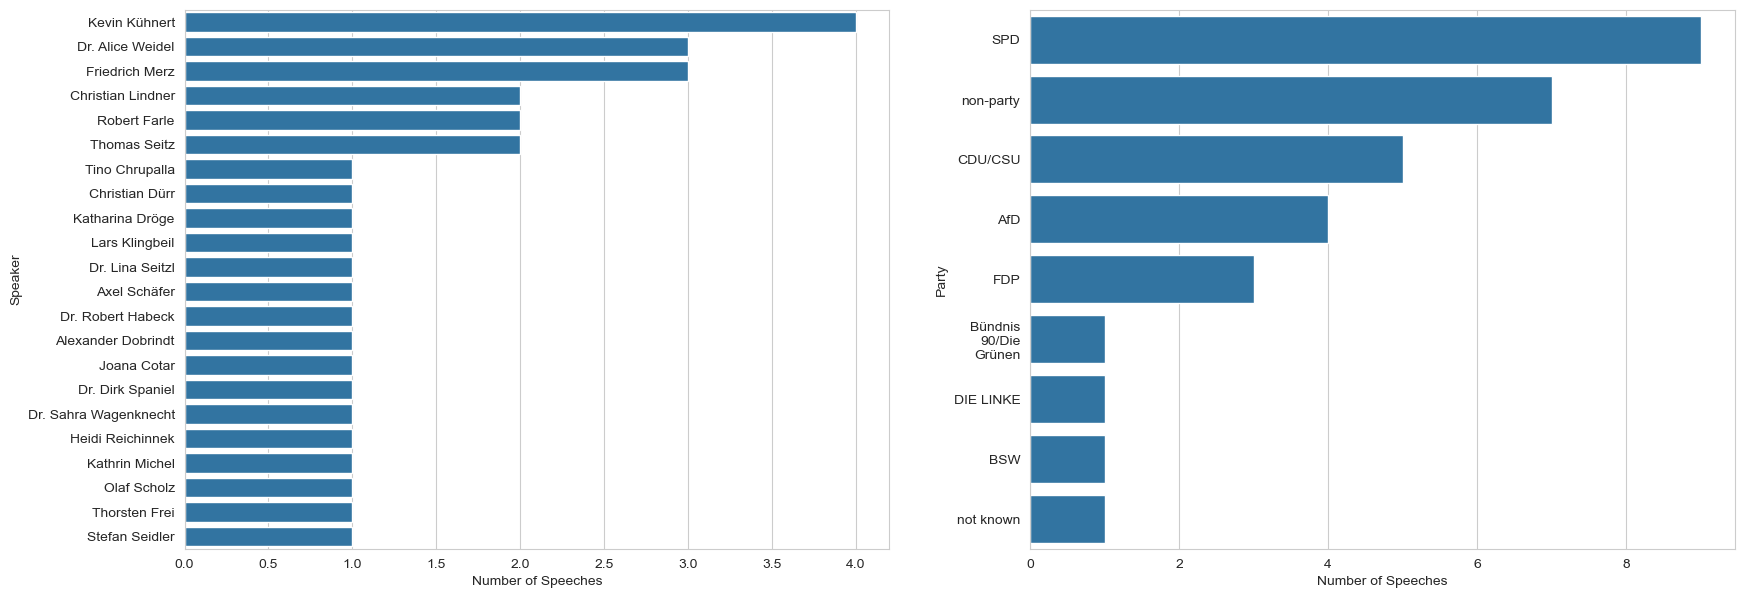

In [13]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(20,7))

gs = fig.add_gridspec(nrows=1, ncols=2, hspace = 0.2)

grid = fig.add_subplot(gs[0, 0])
grid = sns.countplot(sel,
                     y="name",
                     order = sel['name'].value_counts().index)
grid.set(ylabel='Speaker', xlabel = 'Number of Speeches')


grid2 = fig.add_subplot(gs[0, 1])
grid2 = sns.countplot(sel,
                     y="party",
                     order = sel['party'].value_counts().index)
wrap_y_labels(grid2, 12, 0)
grid2.set(ylabel='Party', xlabel = 'Number of Speeches')

plt.show()

# Show number of interjections per speaker and party

In [15]:
# Step 1: Explode the ‘_source.text_raw’ column so that each dictionary becomes a separate row
df_exploded = sel[['speech_id', 'name', 'party', 'text_raw']].explode('text_raw')
# Step 2: Converts the dictionaries in the ‘to_check’ column into separate columns
dict_df = pd.json_normalize(df_exploded['text_raw'])
# Step 3: Add the normalised columns to the original DataFrame (without ‘_source.text_raw’)
result = df_exploded.drop(columns=['text_raw']).reset_index(drop=True).join(dict_df)

In [16]:
# Select only interjections
sel_itj = result[result['type'] == 'interjection']

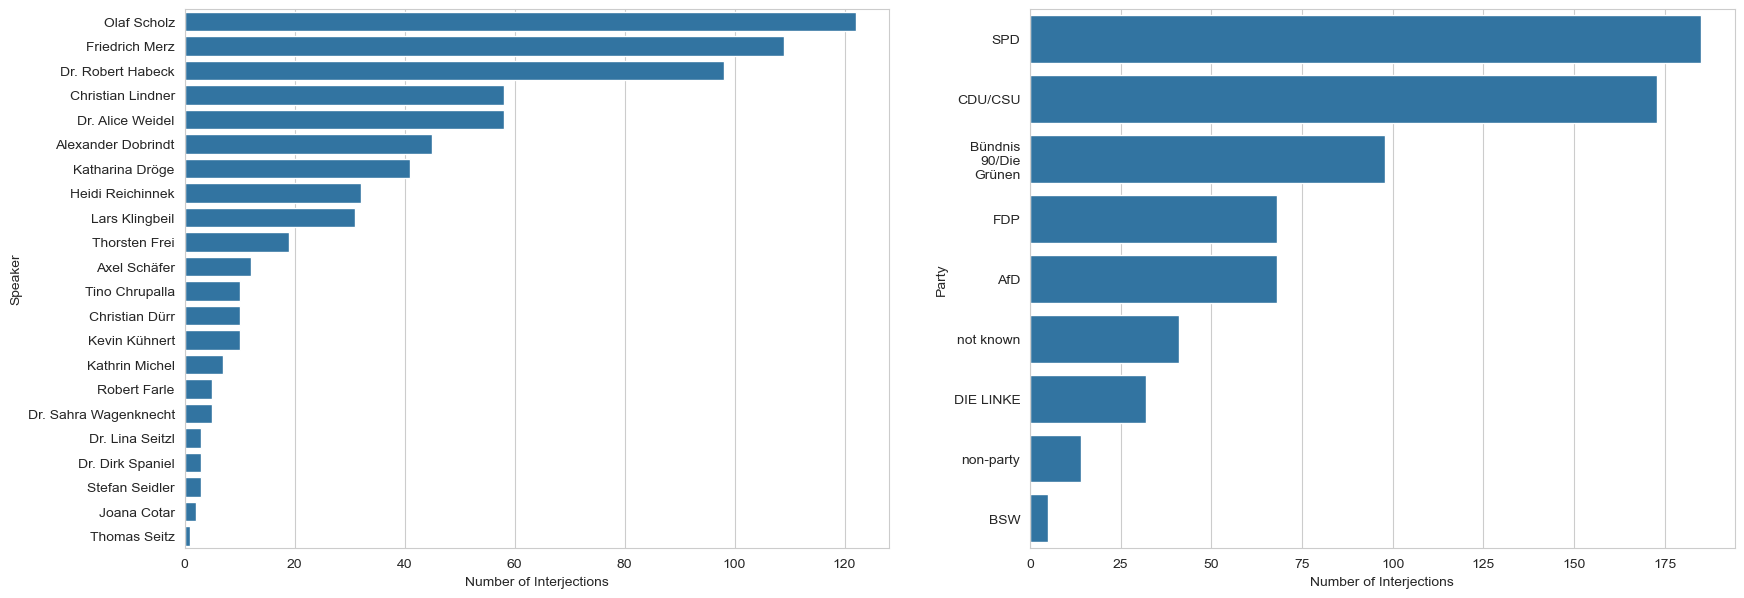

In [17]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(20,7))

gs = fig.add_gridspec(nrows=1, ncols=2, hspace = 0.2)

grid = fig.add_subplot(gs[0, 0])
grid = sns.countplot(sel_itj,
                     y="name",
                     order = sel_itj['name'].value_counts().index)
grid.set(ylabel='Speaker', xlabel = 'Number of Interjections')


grid2 = fig.add_subplot(gs[0, 1])
grid2 = sns.countplot(sel_itj,
                     y="party",
                     order = sel_itj['party'].value_counts().index)
wrap_y_labels(grid2, 12, 0)
grid2.set(ylabel='Party', xlabel = 'Number of Interjections')

plt.show()

## Create wordcloud

In [18]:
# Import libraries
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import numpy as np

In [19]:
# Download stop word for German
stops = set(stopwords.words('german'))
add_stops = {'damen', 'herren', 'herr', 'frau', 'kollege', 'kollegen'}
stops.update(add_stops)

### CDU/CSU

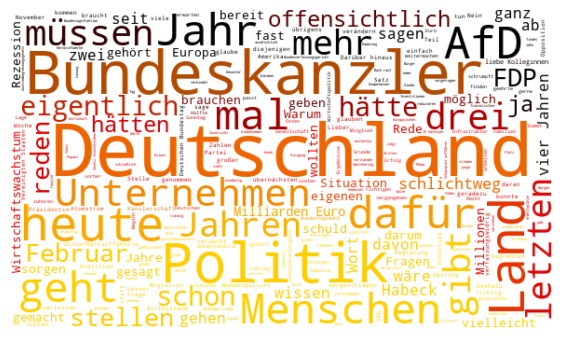

In [20]:
# Select only speeches by CDU/CSU and not by session's president
sel_wcl = result[(result['type'] != 'interjection') & (result['party'] == 'CDU/CSU')]
text = " ".join(s.strip() for s in sel_wcl.text.to_list())
# Generate a word cloud image
mask = np.array(Image.open("german_flag.PNG"))
wordcloud_por = WordCloud(stopwords=stops, background_color="white", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")


plt.show()


### AfD

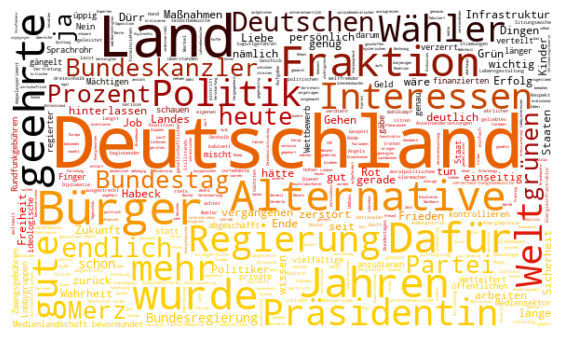

In [21]:
# Select only speeches by AfD and not by session's president
sel_wcl = result[(result['type'] != 'interjection') & (result['party'] == 'AfD')]
text = " ".join(s.strip() for s in sel_wcl.text.to_list())
# Generate a word cloud image
mask = np.array(Image.open("german_flag.PNG"))
wordcloud_por = WordCloud(stopwords=stops, background_color="white", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")


plt.show()

### Bündnis 90/Die Grünen

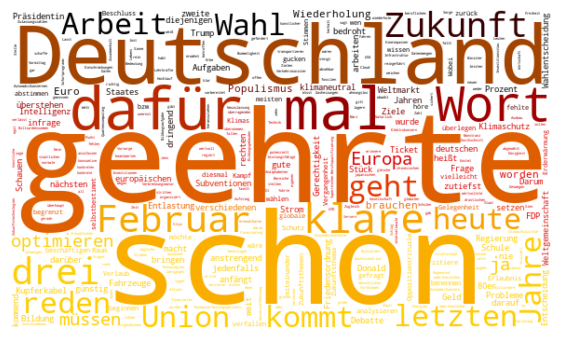

In [22]:
# Select only speeches by Bündnis 90/Die Grünen and not by session's president
sel_wcl = result[(result['type'] != 'interjection') & (result['party'] == 'Bündnis 90/Die Grünen')]
text = " ".join(s.strip() for s in sel_wcl.text.to_list())
# Generate a word cloud image
mask = np.array(Image.open("german_flag.PNG"))
wordcloud_por = WordCloud(stopwords=stops, background_color="white", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")


plt.show()

# Named Entities

In [23]:
# Step 1: Explode the ‘_source.text_raw’ column so that each dictionary becomes a separate row
result_exploded = result[['speech_id', 'name', 'party', 'type', 'ner']].explode('ner')
# Step 2: Converts the dictionaries in the ‘to_check’ column into separate columns
dict_result = pd.json_normalize(result_exploded['ner'])
# Step 3: Add the normalised columns to the original DataFrame (without ‘_source.text_raw’)
result_ne = result_exploded.drop(columns=['ner']).reset_index(drop=True).join(dict_result)

### CDU/CSU

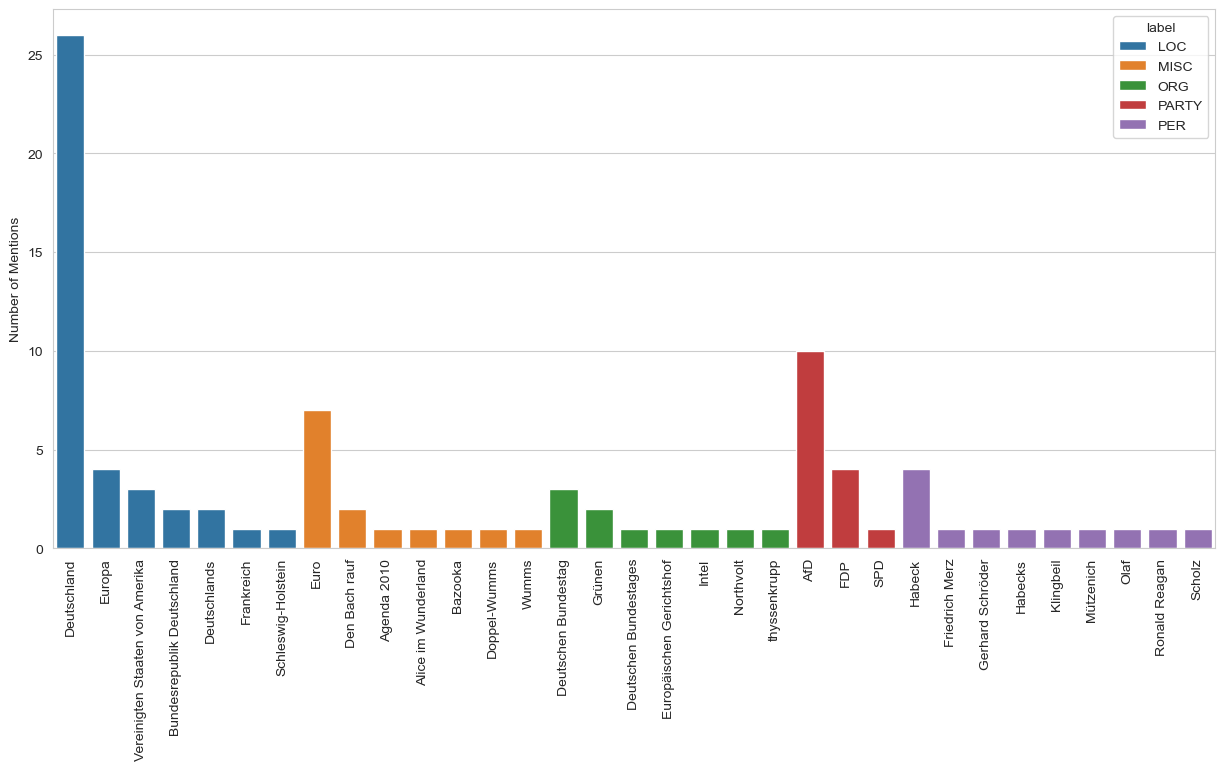

In [24]:
# Select only speeches by CDU/CSU and not by session's president
sel_ne = result_ne[(result_ne['type'] != 'interjection') & (result_ne['party'] == 'CDU/CSU')]

sel_ne_counts = sel_ne.groupby('label')['text'].value_counts().reset_index()

sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,7))

grid = sns.barplot(sel_ne_counts,
                     x="text",
                     y = 'count',
                     hue = 'label'
                    )
grid.set(ylabel='Number of Mentions', xlabel = '')
plt.xticks(rotation=90)

plt.show()

### AfD

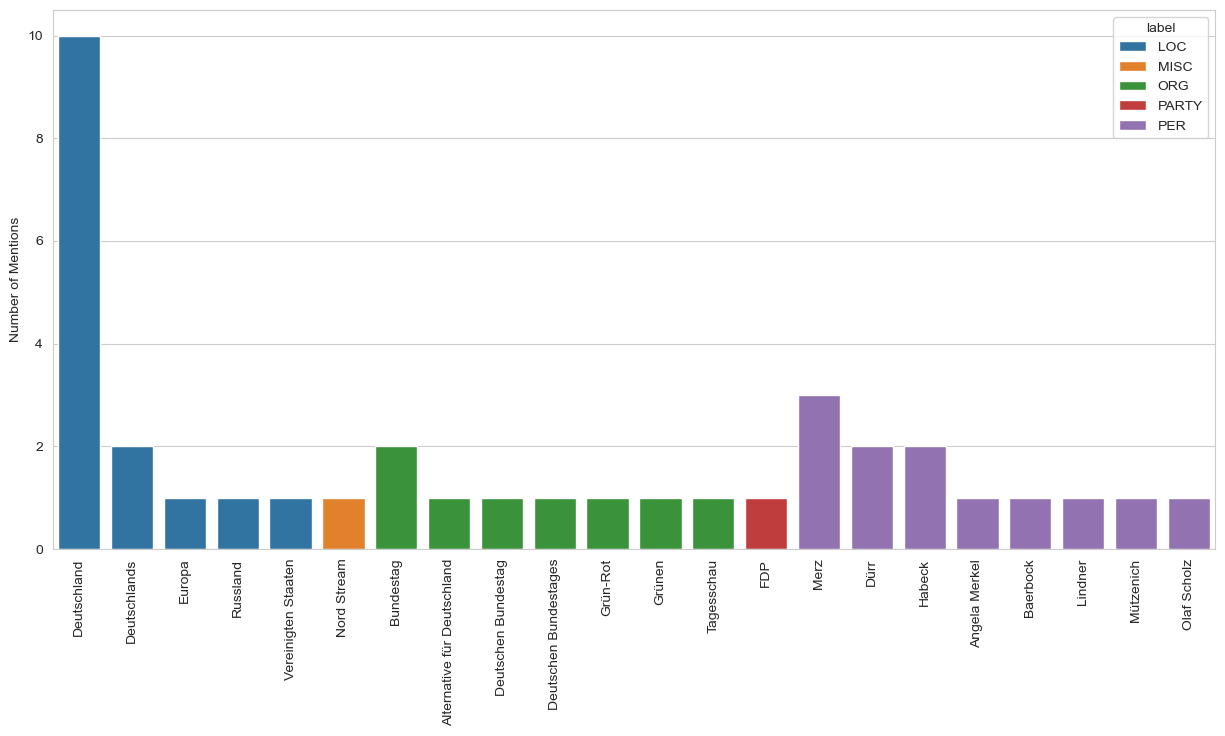

In [25]:
# Select only speeches by AfD and not by session's president
sel_ne = result_ne[(result_ne['type'] != 'interjection') & (result_ne['party'] == 'AfD')]

sel_ne_counts = sel_ne.groupby('label')['text'].value_counts().reset_index()

sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,7))

grid = sns.barplot(sel_ne_counts,
                     x="text",
                     y = 'count',
                     hue = 'label'
                    )
grid.set(ylabel='Number of Mentions', xlabel = '')
plt.xticks(rotation=90)

plt.show()

### Bündnis 90/Die Grünen

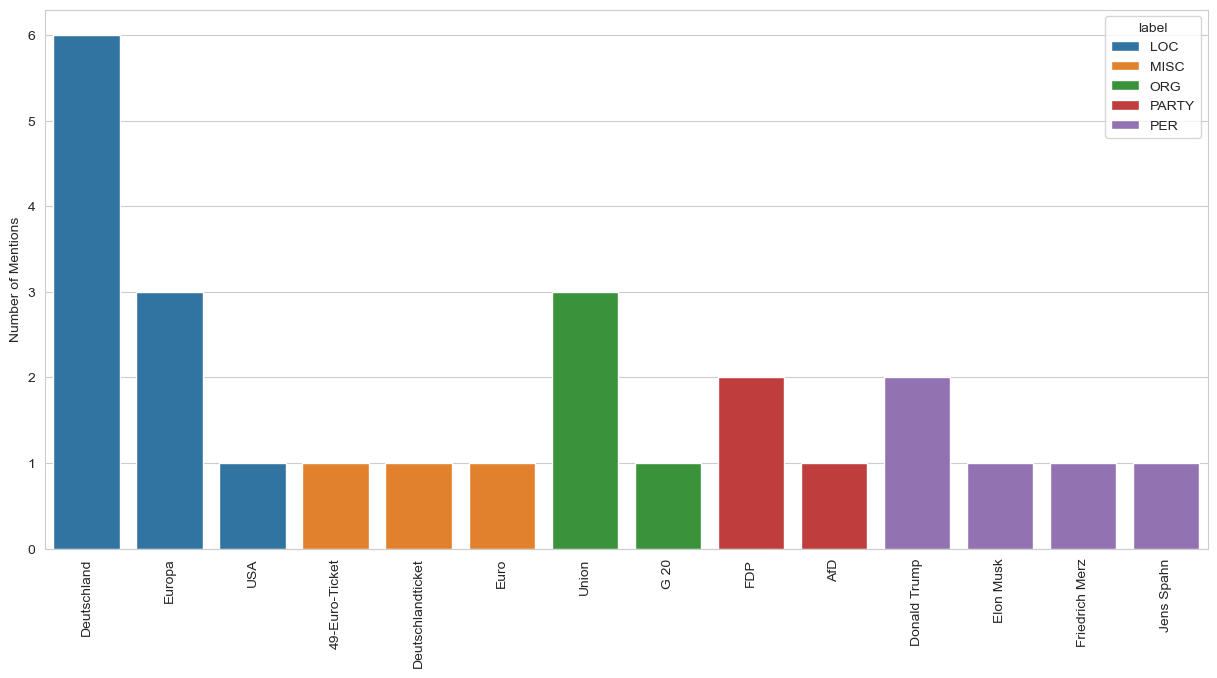

In [26]:
# Select only speeches by 'Bündnis 90/Die Grünen' and not by session's president
sel_ne = result_ne[(result_ne['type'] != 'interjection') & (result_ne['party'] == 'Bündnis 90/Die Grünen')]

sel_ne_counts = sel_ne.groupby('label')['text'].value_counts().reset_index()

sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,7))

grid = sns.barplot(sel_ne_counts,
                     x="text",
                     y = 'count',
                     hue = 'label'
                    )
grid.set(ylabel='Number of Mentions', xlabel = '')
plt.xticks(rotation=90)

plt.show()